In [16]:
import scanpy as sc
import anndata as ad
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
cell_file = "data/cells.npy"

cells = np.load(cell_file, allow_pickle=True).ravel()[0]

expressions = cells["UMI"].toarray()  # sparse matrix of gene expressions
gene_names = cells["gene_ids"]  # gene names
cell_classes = cells["classes"]  # cell classes

In [3]:
expressions[expressions!=0]

array([1., 1., 1., ..., 2., 3., 4.], dtype=float32)

In [4]:
np.unique(expressions)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 112., 113., 114., 115., 116., 117., 119., 120., 121., 123.,
       166., 193., 203., 210., 213., 242., 251., 259., 260.],
      dtype=float32)

In [5]:
np.sum(expressions==0)

np.int64(1070896772)

In [6]:
expressions.size

1105798167

In [7]:
if os.path.exists('data/train_indices.npy'):
    training_indices = np.load('data/train_indices.npy')
    val_indices = np.load('data/val_indices.npy')
    test_indices = np.load('data/test_indices.npy')
else:
    num_cells = expressions.shape[0]
    training_indices = np.random.choice(num_cells, int(0.6*num_cells), replace=False)
    val_test_indices = np.setdiff1d(np.arange(num_cells), training_indices)
    num_cells_left = len(val_test_indices)
    val_indices = np.random.choice(num_cells_left, int(0.5*num_cells_left), replace=False)
    test_indices = np.setdiff1d(np.arange(num_cells), np.concatenate([training_indices,val_indices]))
    np.save('data/train_indices.npy', training_indices)
    np.save('data/val_indices.npy', val_indices)
    np.save('data/test_indices.npy', test_indices)

In [8]:
expressions_train = expressions[training_indices,:]
cell_classes_train = cell_classes[training_indices]

In [9]:
adata = ad.AnnData(X=expressions, obs={'cell_class': cell_classes}, var={'gene_names': gene_names})
adata.var_names = adata.var['gene_names']

adata_train = ad.AnnData(X=expressions_train, obs={'cell_class': cell_classes_train}, var={'gene_names': gene_names})
adata_train.var_names = adata_train.var['gene_names']

In [10]:
adata.obs['cell_class'].value_counts()

cell_class
CD8+ Cytotoxic T                20307
CD8+/CD45RA+ Naive Cytotoxic    16361
CD56+ NK                         8522
CD4+/CD25 T Reg                  6116
CD19+ B                          5579
CD4+/CD45RO+ Memory              3031
Dendritic                        1946
CD14+ Monocyte                   1944
CD4+/CD45RA+/CD25- Naive T       1857
CD34+                             188
CD4+ T Helper2                     92
Name: count, dtype: int64

In [11]:
adata.layers['counts'] = adata.X.copy()

In [12]:
sc.pp.normalize_total(adata)

In [13]:
sc.pp.log1p(adata)

In [14]:
adata

AnnData object with n_obs × n_vars = 65943 × 16769
    obs: 'cell_class'
    var: 'gene_names'
    uns: 'log1p'
    layers: 'counts'

In [15]:
adata.obs

,cell_class
0,CD8+ Cytotoxic T
1,CD8+/CD45RA+ Naive Cytotoxic
2,CD4+/CD45RO+ Memory
3,CD19+ B
4,CD4+/CD25 T Reg
...,...
65938,CD8+/CD45RA+ Naive Cytotoxic
65939,CD8+ Cytotoxic T
65940,CD8+/CD45RA+ Naive Cytotoxic
65941,CD8+ Cytotoxic T


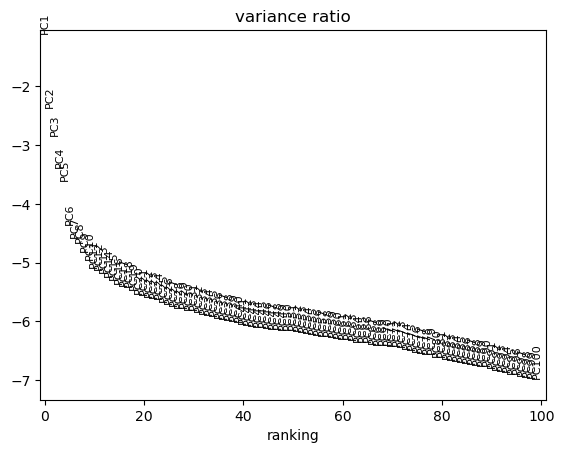

<Figure size 640x480 with 0 Axes>

In [17]:
n_comp = 100
sc.tl.pca(adata_train, n_comps=n_comp)
sc.pl.pca_variance_ratio(adata_train, n_pcs=n_comp, log=True)
plt.savefig("plots/pca_var_ratio.png")

In [18]:
sc.pp.neighbors(adata_train)

/Users/easwaranramamurthy/miniforge3/envs/sc_gen_bio/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
sc.tl.umap(adata_train)

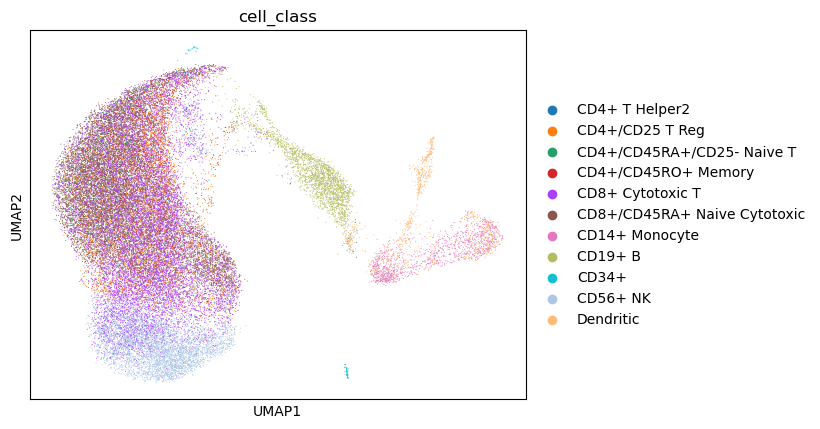

<Figure size 640x480 with 0 Axes>

In [20]:
sc.pl.umap(
    adata_train,
    color="cell_class",
    # Setting a smaller point size to get prevent overlap
    size=2,
)
plt.savefig("plots/train_umap.png")

In [21]:
np.save('data/normed_transformed_data.npy', adata.X)
np.save('data/gene_ids.npy', gene_names)
np.save('data/cell_classes.npy', cell_classes)